# Retail Analysis with Walmart Data

In [14]:
# Importing Required Libraries

%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# configure your folder and filenames
DATA_FOLDER = r'D:/Microsoft AI Engineer Program/Applied Data Science With Python/1577429980_walmart_store_sales'
CSV_FILENAME = 'Walmart_Store_sales.csv'
OUT_DIR = "outputs"
PLOTS_DIR = os.path.join(OUT_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)


In [15]:
# Loading Walmart Sales Dataset

csv_path = os.path.join(DATA_FOLDER, CSV_FILENAME)
print("Reading:", csv_path)
df = pd.read_csv(csv_path)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date']).sort_values(['Store','Date']).reset_index(drop=True)
df.head()


Reading: D:/Microsoft AI Engineer Program/Applied Data Science With Python/1577429980_walmart_store_sales\Walmart_Store_sales.csv


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-01-10,1453329.50,0,71.89,2.603,211.671989,7.838
1,1,2010-02-04,1594968.28,0,62.27,2.719,210.820450,7.808
2,1,2010-02-07,1492418.14,0,80.91,2.669,211.223533,7.787
3,1,2010-03-09,1540163.53,0,81.21,2.577,211.531248,7.787
4,1,2010-03-12,1548033.78,0,49.27,2.708,211.607193,7.838


In [16]:
# Store Statistics (Total Sales, Mean, Std Dev, Coefficient of Variation)

store_total = df.groupby('Store', as_index=False)['Weekly_Sales'].sum().rename(columns={'Weekly_Sales':'Total_Sales'})
store_stats = df.groupby('Store')['Weekly_Sales'].agg(['mean','std']).reset_index()
store_stats['coef_var'] = store_stats['std'] / store_stats['mean']

# display top stores
display(store_total.sort_values('Total_Sales', ascending=False).head(10))
display(store_stats.sort_values('std', ascending=False).head(10))

# save
store_total.to_csv(os.path.join(OUT_DIR,'store_total_sales.csv'), index=False)
store_stats.to_csv(os.path.join(OUT_DIR,'store_stats_mean_std_cv.csv'), index=False)


,Store,Total_Sales
19,20,1.236541e+08
3,4,1.190478e+08
13,14,1.182858e+08
12,13,1.138956e+08
1,2,1.112614e+08
9,10,1.085998e+08
26,27,1.016186e+08
0,1,9.130517e+07
5,6,9.056853e+07
18,19,8.371544e+07


,Store,mean,std,coef_var
13,14,2.075189e+06,224425.651713,0.108147
26,27,1.782782e+06,180950.058463,0.101499
9,10,1.905260e+06,178732.213234,0.093810
19,20,2.169370e+06,167719.243678,0.077312
34,35,9.252588e+05,165835.457210,0.179231
22,23,1.392810e+06,157337.342275,0.112964
3,4,2.088557e+06,153324.594500,0.073412
38,39,1.435258e+06,139820.503036,0.097418
12,13,1.998168e+06,139551.509961,0.069840
5,6,1.588922e+06,131430.550525,0.082717


In [17]:
# Store with Maximum Sales & Quarterly Growth (Q2 → Q3 2012)

q2_mask = (df['Date'] >= '2012-04-01') & (df['Date'] <= '2012-06-30')
q3_mask = (df['Date'] >= '2012-07-01') & (df['Date'] <= '2012-09-30')

q2 = df[q2_mask].groupby('Store', as_index=False)['Weekly_Sales'].sum().rename(columns={'Weekly_Sales':'Q2_2012_Sales'})
q3 = df[q3_mask].groupby('Store', as_index=False)['Weekly_Sales'].sum().rename(columns={'Weekly_Sales':'Q3_2012_Sales'})

q_growth = pd.merge(q2, q3, on='Store', how='outer').fillna(0)
q_growth['growth_abs'] = q_growth['Q3_2012_Sales'] - q_growth['Q2_2012_Sales']
q_growth['growth_pct'] = np.where(q_growth['Q2_2012_Sales'] != 0,
                                  q_growth['growth_abs'] / q_growth['Q2_2012_Sales'] * 100,
                                  np.nan)
q_growth = q_growth.sort_values('growth_pct', ascending=False)
display(q_growth.head(10))
q_growth.to_csv(os.path.join(OUT_DIR,'q2_q3_2012_growth_per_store.csv'), index=False)


,Store,Q2_2012_Sales,Q3_2012_Sales,growth_abs,growth_pct
34,35,4155582.19,2654599.71,-1500982.48,-36.119668
32,33,1352602.83,859857.83,-492745.00,-36.429393
15,16,2607204.97,1636709.13,-970495.84,-37.223611
13,14,9734242.62,6024967.53,-3709275.09,-38.105431
41,42,3109823.99,1919892.98,-1189931.01,-38.263613
27,28,7440072.28,4591145.74,-2848926.54,-38.291651
11,12,5142747.75,3154586.08,-1988161.67,-38.659521
12,13,10360261.14,6334679.86,-4025581.28,-38.855983
20,21,3444566.26,2105807.41,-1338758.85,-38.865818
35,36,1556678.20,950676.88,-606001.32,-38.929133


In [18]:
# Store with Maximum Std Dev & Holiday vs Non-Holiday Sales Analysis

holiday_dates = {
    'Super Bowl': ['2010-02-12','2011-02-11','2012-02-10'],
    'Labour Day': ['2010-09-10','2011-09-09','2012-09-07'],
    'Thanksgiving': ['2010-11-26','2011-11-25','2012-11-23'],
    'Christmas': ['2010-12-31','2011-12-30','2012-12-28']
}
holiday_lookup = {}
for name, dates in holiday_dates.items():
    for d in dates:
        holiday_lookup[pd.to_datetime(d)] = name

df['Holiday_Name'] = df['Date'].map(holiday_lookup).fillna('None')
non_holiday_mean = df[df['Holiday_Flag'] == 0]['Weekly_Sales'].mean()
holiday_means = df[df['Holiday_Name'] != 'None'].groupby('Holiday_Name', as_index=False)['Weekly_Sales'].mean().rename(columns={'Weekly_Sales':'Mean_Weekly_Sales'})
holiday_means['Higher_than_NonHoliday'] = holiday_means['Mean_Weekly_Sales'] > non_holiday_mean

print("Non-holiday mean:", non_holiday_mean)
display(holiday_means)
holiday_means.to_csv(os.path.join(OUT_DIR,'holiday_means_vs_nonholiday.csv'), index=False)


Non-holiday mean: 1059765.4008671022


,Holiday_Name,Mean_Weekly_Sales,Higher_than_NonHoliday
0,Labour Day,1039182.834,False


,month,Total_Sales,month_str
0,2010-01,4.223988e+07,2010-01
1,2010-02,9.934132e+07,2010-02
2,2010-03,9.710329e+07,2010-03
3,2010-04,5.018854e+07,2010-04
4,2010-05,1.424042e+08,2010-05


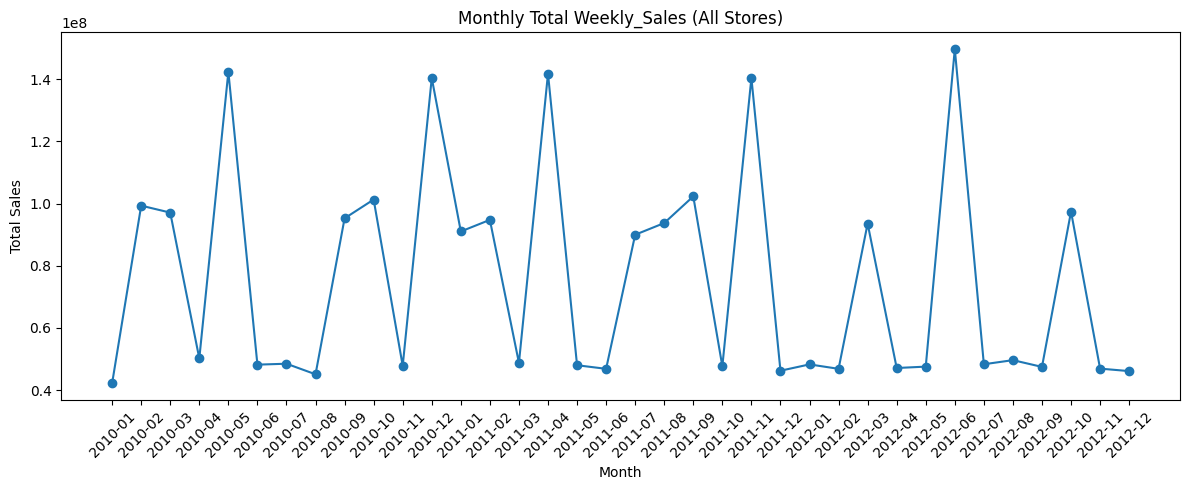

,year,semester,Total_Sales,label
0,2010,H1,4.794822e+08,2010-H1
1,2010,H2,4.783856e+08,2010-H2
2,2011,H1,4.712434e+08,2011-H1
3,2011,H2,5.204156e+08,2011-H2
4,2012,H1,4.331158e+08,2012-H1
5,2012,H2,3.359289e+08,2012-H2


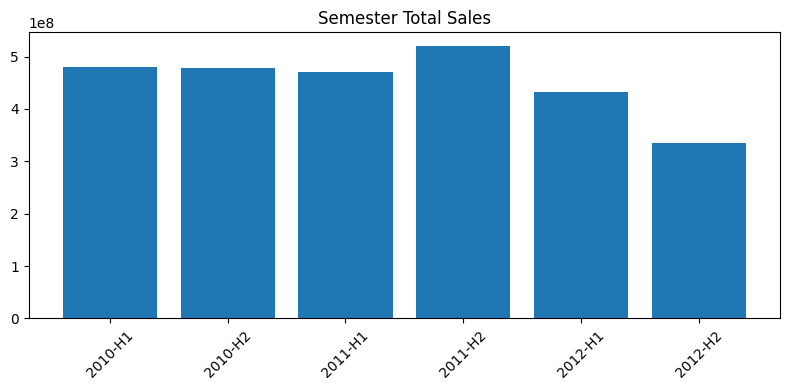

In [19]:
# Quarterly Growth in Q3 2012 + Monthly & Semester Aggregates

# monthly
df['month'] = df['Date'].dt.to_period('M')
monthly = df.groupby('month', as_index=False)['Weekly_Sales'].sum().rename(columns={'Weekly_Sales':'Total_Sales'})
monthly['month_str'] = monthly['month'].dt.strftime('%Y-%m')
display(monthly.head())

# plot monthly totals
plt.figure(figsize=(12,5))
plt.plot(monthly['month_str'], monthly['Total_Sales'], marker='o')
plt.xticks(rotation=45)
plt.title('Monthly Total Weekly_Sales (All Stores)')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR,'monthly_total_sales_allstores.png'))
plt.show()

# semester
df['year'] = df['Date'].dt.year
df['semester'] = np.where(df['Date'].dt.month <= 6, 'H1', 'H2')
semester = df.groupby(['year','semester'], as_index=False)['Weekly_Sales'].sum().rename(columns={'Weekly_Sales':'Total_Sales'})
semester['label'] = semester['year'].astype(str) + '-' + semester['semester']
display(semester)
plt.figure(figsize=(8,4))
plt.bar(semester['label'], semester['Total_Sales'])
plt.xticks(rotation=45)
plt.title('Semester Total Sales')
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR,'semester_total_sales.png'))
plt.show()

monthly.to_csv(os.path.join(OUT_DIR,'monthly_total_sales_allstores.csv'), index=False)
semester.to_csv(os.path.join(OUT_DIR,'semester_total_sales.csv'), index=False)


In [20]:
# Prepared Data for Store 1 Forecasting

store1 = df[df['Store'] == 1].copy().sort_values('Date').reset_index(drop=True)
min_date = df['Date'].min()
store1['day_index'] = (store1['Date'] - min_date).dt.days + 1  # earliest -> 1

# ensure econ features present
for c in ['CPI','Unemployment','Fuel_Price','Temperature','Holiday_Flag']:
    if c not in store1.columns:
        store1[c] = 0

# convert and impute (use .ffill()/.bfill() to avoid deprecation warnings)
store1[['CPI','Unemployment','Fuel_Price','Temperature']] = (
    store1[['CPI','Unemployment','Fuel_Price','Temperature']]
    .apply(pd.to_numeric, errors='coerce')
    .ffill().bfill().fillna(0)
)
store1['Holiday_Flag'] = store1['Holiday_Flag'].fillna(0).astype(int)

# time split
n = len(store1)
split_idx = int(n * 0.8)
train = store1.iloc[:split_idx]
test = store1.iloc[split_idx:]

# features
features_date = ['day_index']
features_econ = ['day_index','CPI','Unemployment','Fuel_Price','Temperature','Holiday_Flag']

def fit_eval(X_cols):
    model = LinearRegression()
    X_train = train[X_cols].values
    y_train = train['Weekly_Sales'].values
    X_test = test[X_cols].values
    y_test = test['Weekly_Sales'].values
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # compute RMSE in a way compatible across sklearn versions:
    mse = mean_squared_error(y_test, y_pred)   # returns MSE
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return model, y_test, y_pred, rmse, mae, r2

m_date, y_test_d, y_pred_d, rmse_d, mae_d, r2_d = fit_eval(features_date)
m_econ, y_test_e, y_pred_e, rmse_e, mae_e, r2_e = fit_eval(features_econ)

print("Date-only RMSE:", rmse_d, "Date+Econ RMSE:", rmse_e)
pd.DataFrame([
    {'Model':'Date_only','RMSE':rmse_d,'MAE':mae_d,'R2':r2_d},
    {'Model':'Date_plus_econ','RMSE':rmse_e,'MAE':mae_e,'R2':r2_e}
])


Date-only RMSE: 108417.62998979383 Date+Econ RMSE: 101542.76508819421


,Model,RMSE,MAE,R2
0,Date_only,108417.629990,85476.15481,-0.251837
1,Date_plus_econ,101542.765088,76324.23545,-0.098110


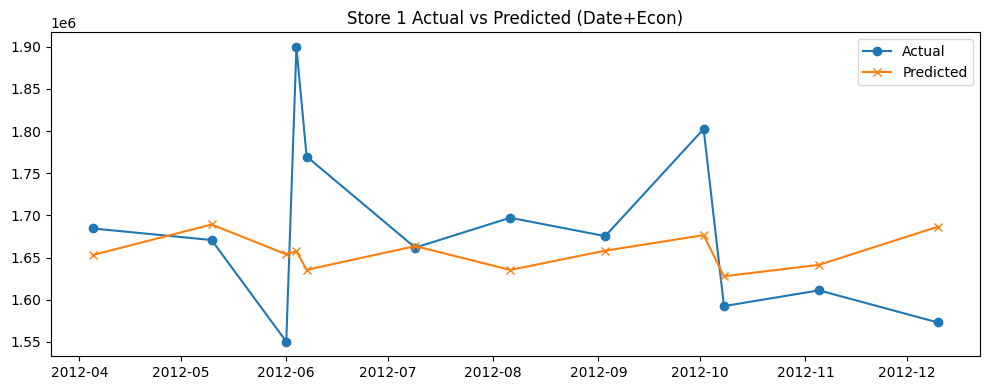

Saved test+predictions to: outputs\store1_test_with_predictions.csv


In [21]:
# Linear Regression Models

best_y_test, best_y_pred = (y_test_d, y_pred_d) if rmse_d <= rmse_e else (y_test_e, y_pred_e)
label = 'Date-only' if rmse_d <= rmse_e else 'Date+Econ'

plt.figure(figsize=(10,4))
plt.plot(test['Date'], best_y_test, marker='o', label='Actual')
plt.plot(test['Date'], best_y_pred, marker='x', label='Predicted')
plt.title(f"Store 1 Actual vs Predicted ({label})")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR,'store1_actual_vs_predicted.png'))
plt.show()

# save test + predictions to CSV
test_out = test[['Date','Weekly_Sales','day_index','CPI','Unemployment','Fuel_Price','Temperature','Holiday_Flag']].copy()
test_out['Predicted'] = best_y_pred
test_out.to_csv(os.path.join(OUT_DIR,'store1_test_with_predictions.csv'), index=False)
print("Saved test+predictions to:", os.path.join(OUT_DIR,'store1_test_with_predictions.csv'))


Train size: (100, 9)  Test size: (43, 9)
Features used: ['Days', 'CPI', 'Fuel_Price', 'Unemployment']


,Feature,Coef,StdErr,tStat,pValue
0,Intercept,-4.101269e+06,3.692645e+06,-1.110659,0.269518
1,Days,2.893041e+01,2.479424e+02,0.116682,0.907358
2,CPI,3.294242e+04,1.897016e+04,1.736539,0.085710
3,Fuel_Price,-1.528846e+05,6.379651e+04,-2.396441,0.018513
4,Unemployment,-1.188453e+05,1.590641e+05,-0.747153,0.456816



Manual OLS Test metrics: RMSE=291057.36, MAE=263873.14, R2=-5.5488


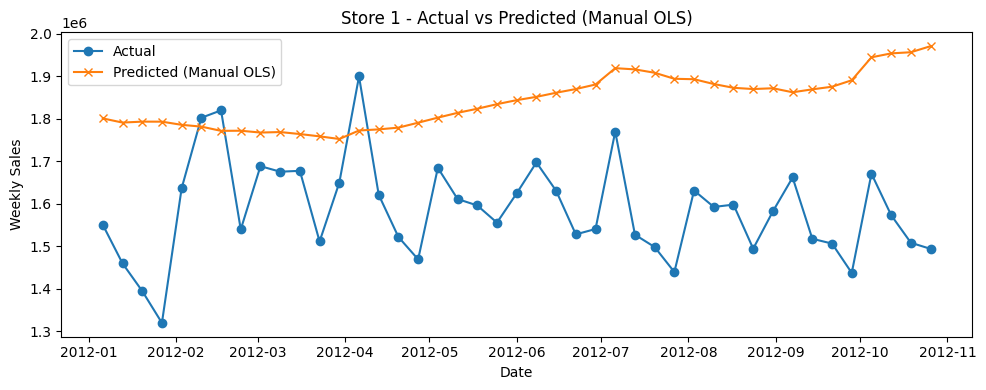

In [ ]:
# Manual OLS Regression for Store 1

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


path = "D:/Microsoft AI Engineer Program/Applied Data Science With Python/1577429980_walmart_store_sales/"
df = pd.read_csv(path + "Walmart_Store_sales.csv")


store1 = df[df['Store'] == 1].copy()
store1['Date'] = pd.to_datetime(store1['Date'], dayfirst=True)
store1 = store1.sort_values('Date').reset_index(drop=True)

# Add time variable (Days since first date)
store1['Days'] = (store1['Date'] - store1['Date'].min()).dt.days

# Features for regression
features_econ = ['Days', 'CPI', 'Fuel_Price', 'Unemployment']

# Train-test split (before 2012 = train, after 2012 = test)
train = store1[store1['Date'] < '2012-01-01'].copy()
test  = store1[store1['Date'] >= '2012-01-01'].copy()

print("Train size:", train.shape, " Test size:", test.shape)
print("Features used:", features_econ)


OUT_DIR = "outputs"
PLOTS_DIR = os.path.join(OUT_DIR, "plots")
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

# Prepare X, y
X_train = train[features_econ].astype(float).values
y_train = train['Weekly_Sales'].astype(float).values
n, p = X_train.shape

# Add intercept
X_train_const = np.concatenate([np.ones((n,1)), X_train], axis=1)

# OLS solution
XtX_inv = np.linalg.pinv(X_train_const.T.dot(X_train_const))
beta_hat = XtX_inv.dot(X_train_const.T).dot(y_train)

# Predictions + residuals
y_pred_train = X_train_const.dot(beta_hat)
residuals = y_train - y_pred_train
SSR = np.sum(residuals**2)
df_resid = max(n - (p+1), 1)

# Variance + std error
sigma2_hat = SSR / df_resid
cov_beta = sigma2_hat * XtX_inv
se_beta = np.sqrt(np.diag(cov_beta))

# t-stats
t_stats = beta_hat / se_beta

# p-values (try scipy, else z-approx)
try:
    from scipy import stats
    p_values = 2.0 * stats.t.sf(np.abs(t_stats), df=df_resid)
except:
    import math
    def normal_cdf(z): return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))
    p_values = [2*(1-normal_cdf(abs(t))) for t in t_stats]

# Coef table
feature_names = ['Intercept'] + features_econ
coef_table = pd.DataFrame({
    'Feature': feature_names,
    'Coef': beta_hat,
    'StdErr': se_beta,
    'tStat': t_stats,
    'pValue': p_values
})
display(coef_table)

# Save coefficients
coef_table.to_csv(os.path.join(OUT_DIR, "store1_ols_coefs.csv"), index=False)


# Evaluate on test set

X_test = test[features_econ].astype(float).values
y_test = test['Weekly_Sales'].astype(float).values
X_test_const = np.concatenate([np.ones((X_test.shape[0],1)), X_test], axis=1)

y_pred_test = X_test_const.dot(beta_hat)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae  = mean_absolute_error(y_test, y_pred_test)
r2   = r2_score(y_test, y_pred_test)

print(f"\nManual OLS Test metrics: RMSE={rmse:.2f}, MAE={mae:.2f}, R2={r2:.4f}")

# Save test results
test_out = test[['Date','Weekly_Sales'] + features_econ].copy()
test_out['Predicted_OLS'] = y_pred_test
test_out.to_csv(os.path.join(OUT_DIR, "store1_test_predictions.csv"), index=False)

# Plot
plt.figure(figsize=(10,4))
plt.plot(test['Date'], y_test, marker='o', label="Actual")
plt.plot(test['Date'], y_pred_test, marker='x', label="Predicted (Manual OLS)")
plt.title("Store 1 - Actual vs Predicted (Manual OLS)")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "store1_actual_vs_pred_manual_ols.png"))
plt.show()
